# Anxiety of Conception Algorithm

This notebook contains the code and explanation for how the poems of my book, "The Anxiety of Conception," are ordered. 

I wrote one hundred prose poems (single paragraphs) in the year prior to J's birth, and one hundred in the year after. Let's call these two sets of poems **poems a** (pre-birth poems) and **poems b** (post-birth poems). The book also has two parts: *PART 1* and *PART 2*. In the first printings, most poems from **poems a** are in *PART 1*, but over time the poems begin to swap and get muddled, such that by the 200th book the poems are mostly shuffled.

How are the poems shuffled? There is an algorithm which calculates a score for how "well" a poem would go after another one. Some poems go well together---these get a low score (or `small distance`; this terminology will be explained later)---others don't match very well and get a high score (or `large distance`). As books are printed, poems are rearranged according to this score, such that poems that go "well" together according to their score are adjacent, even if very far apart in the original ordering.

## Step 1: Import the poems

### Text import

Import poems from **poems a** and **poems b**. Subset each set to just 100 poems each. (Eventually there should just be exactly 100 poems in each part.) Then put them together into one large list which is referenced for the rest of the code, and just know that the first 100 are from **poems a** and the second 100 from **poems b**.

The output of the algorithm which creates books will be an ordering: this will be a list of indices of this original list of poems. i.e. There are poems 0, 1, 2, 3, 4, ... 199. The output will be a list something like 5, 90, 23, 1, ... 182, representing the order in which the poems should be printed in the book.

Note that the imported text looks something like:

```
[1] Poem text here.

[2] Another poem text here.
```

Right now I'm removing the numbers in brackets, but I may consider putting them back later.

### Words and stems

In addition to tracking the raw text of each poem, I also split each poem into a list of lowercase words with punctuation removed, and a list of word stems (e.g. instead of "computer" the word becomes the stem "comput"). This is then used when calculating the score (or distance) between poems, as described later.

In [1]:
import string
from nltk.stem.porter import *

stemmer = PorterStemmer()

def simple_tokenize(s):
    """where s is a string of text, raw poem"""
    s = s.lower()
    s = s.translate(str.maketrans('', '', string.punctuation))
    return s.split(" ")

def get_stems(s):
    """where s is a list of lowercase words"""
    return [stemmer.stem(w) for w in s]


data_raw = []
data_tokens = []
data_stems = []

# first add part a
with open("part_a.txt", "r") as fle:
    for line in fle:
        if line[0] == "[":
            text = line.split("]")[1].strip()
            data_raw.append(text)

            tokens = simple_tokenize(text)
            data_tokens.append(tokens)

            stems = get_stems(tokens)
            data_stems.append(stems)

num_poems_a = len(data_raw)

poems_a = list(range(len(data_raw)))

# then add part b
with open("part_b.txt", "r") as fle:
    for line in fle:
        if line[0] == "[":
            text = line.split("]")[1].strip()
            data_raw.append(text)

            tokens = simple_tokenize(text)
            data_tokens.append(tokens)

            stems = get_stems(tokens)
            data_stems.append(stems)

num_poems_b = len(data_raw) - num_poems_a

poems_b = list(range(poems_a[-1]+1, len(data_raw)))

split_index = poems_a[-1] + 1

print(f"POEMS A: {num_poems_a}, POEMS_B: {num_poems_b}")
print(poems_a)
print(poems_b)
print(split_index)
data_raw[0], ' '.join(data_tokens[0]), ' '.join(data_stems[0])

POEMS A: 116, POEMS_B: 101
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
[116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 2

('I visualize two paths my life might take. The one where I have a child and the one where I do not. I try to place them on equal footing, imagining each as something I truly want. Though I know both will be filled with disappointment and loss.',
 'i visualize two paths my life might take the one where i have a child and the one where i do not i try to place them on equal footing imagining each as something i truly want though i know both will be filled with disappointment and loss',
 'i visual two path my life might take the one where i have a child and the one where i do not i tri to place them on equal foot imagin each as someth i truli want though i know both will be fill with disappoint and loss')

## Step 2: Calculate transition scores

i.e. How well one poem flows into another. 

Look at the 10 words at the end of one poem, the 10 at the start of the next. High score is better, but then we'll invert it so that score is more like distance (where lower is better).

Initial score: 0

If a word in poem B is in poem A:

* If not a stop word:
    * +20 if exact word match OR
    * +10 if stemmed word match
* If narrow stop word:
    * +2
* If broad stop word
    * +4
    
Not implemented: 

* Check number of words between them (k) -- could be up to 18
    * -k/4

I'd like this score to be a bit cleaner, and maybe consider distance between words, but this is working pretty well for now.

In [2]:
stopwords_broad = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
stopwords_narrow = ["the", "a", "an"]

def join_score(a, b, n=10):
    """where a and b are indices for the data, and n is num of words to consider"""
    score = 0
    a_tokens = data_tokens[a]
    a_stems = data_stems[a]
    b_tokens = data_tokens[b]
    b_stems = data_stems[b]
    for i in range(min(len(a_tokens), n)): # iterate over words in a
        a_token = a_tokens[-i]
        a_stem = a_stems[-i]
        for j in range(min(len(b_tokens), n)): # iterate over words in b
            b_token = b_tokens[j]
            b_stem = b_stems[j]
            if a_token == b_token: # if there's a matching word
                if a_token in stopwords_narrow:
                    score += 2
                    continue
                if a_token in stopwords_broad:
                    score += 4
                    continue
                score += 20
                continue
            if a_stem == b_stem:
                score += 10
    return 20 - score

p = 2
q = 3
print(data_raw[p], "\n")
print(data_raw[q])
join_score(p, q)

A mood sweeps in like a fog. I no longer know where it came from. I get stuck in circles. I try to ignore the suspense; anger and hurt can do that, but not entirely. Suspense is lodged within me, someplace deep. The fog crawls at my feet. "Let me stay," it mews, and though I definitely want it to leave, it doesn't feel entirely up to me. 

I pause to look carefully at the book cover. I am obsessed with the way books feel. Their aspect ratio, the texture of the paper. If I put my nose close, I can see the dot matrix of the printed artwork. It's not grey; it's white with a multitude of black dots.


12

Calculate the score for all possible pairs of poems. This results in a square matrix the size of how many poems there are (200).

In [3]:
import numpy as np

def calc_all_scores(data, join_score_func):
    scores = np.empty([len(data), len(data)])
    for i in range(len(data)):
        for j in range(len(data)):
            if i == j:
                s = np.nan
            else:
                s = join_score_func(i, j)
            scores[i][j] = s
    return scores

scores = calc_all_scores(data_raw, join_score)

scores

array([[nan, -4., 16., ..., 16., 12., 16.],
       [12., nan, 16., ..., 20., 16.,  4.],
       [20.,  2., nan, ..., 18., 18.,  4.],
       ...,
       [16., 16., 16., ..., nan,  8., 20.],
       [16., 16., 12., ..., 14., nan, 20.],
       [-4., -2., 16., ..., 16., 16., nan]])

## Step 2a: See which poems fit together best

This is just to check that the join scores are working okay.

Remember: lower is better, because the scores are considered as `distances` between the poems.

In [4]:
def get_top_scores(scores, asc=True, n=5):
    flattened = scores.flatten()
    if asc:
        sorted_indices = np.argsort(flattened)
    else:
        sorted_indices = np.argsort(-flattened)
    indices_2d = np.unravel_index(sorted_indices, scores.shape)
    sorted_indices_list = list(zip(indices_2d[0], indices_2d[1]))

    for i, val in enumerate(sorted_indices_list[0:n]):
        print('indices:', val)
        print('score:', scores[val[0],val[1]])
        print('>>>', data_raw[val[0]], '\n>>>>', data_raw[val[1]], '\n')

    return sorted_indices_list

In [5]:
x = get_top_scores(scores, asc=True, n=10)

indices: (196, 105)
score: -140.0
>>> Little dragon, crackling with fire throughout the night. Little lamb, sleeping innocently. Little jellyfish, floating through the kitchen. Little bird, learning to move his limbs. Little dog, barking for more food. Little crab, pinching and cutting. Little fish, wet and slippy. Little goat. Little whale. Little lion. 
>>>> Little dragon without a name. Little bony bird. Alien army. Jellyfish tentacle. Armadillo rolling across the sand. Do armadillos roll? Rolly polly, little bug. Skink with the lost tail flickering around on the other side of my belly. Little lamb with its bony head. Three-headed monster. Twelve-tailed fox. Kangaroo fighting to get out, pushing long legs into my sides. 

indices: (196, 48)
score: -60.0
>>> Little dragon, crackling with fire throughout the night. Little lamb, sleeping innocently. Little jellyfish, floating through the kitchen. Little bird, learning to move his limbs. Little dog, barking for more food. Little crab, p

## Step 3: Reorder the poems according to the scores

### A single tour (if we don't care about the two parts and mixture levels)

This is a traveling salesman problem with assymmetric distances. To keep in line with traveling salesman terminology, each poem is a `city`, and the ordering of the poems is called the `tour`. The scores between poems are `distances`. It's assymmetric because the distance between two poems (cities) depends on their order.

The algorithm calculates a `tour` which visits each city once. I'm going to use a Markov Chain Monte Carlo (MCMC) method to stochastically find a good tour. The basic idea is to start with a random tour, and then randomly swap cities (poems) and check if the new tour is better; if it's better then we keep the new tour, if it's not better we discard it and just try another random swap. If we repeat this many, many times the tours will start to get better and better, even though each swap is random. However, to avoid local minimums, we add some wiggle room (in the code this is the `temperature`) for selecting a slightly less optimal tour. We'll add in what's called simulated annealing, which means we'll decrease the wiggle room as we go on, which has been shown to be a good technique.

### A double tour (caring about the mixture of the two parts)

Actually, I have two tours: the cities (poems) of *PART 1*, and the cities (poems) of *PART 2*. Both should be close-to-optimal, i.e. poems that sit well together should be together. 

<!-- I'd like to be able to create mixtures of part A and part B. To do this, I set a mixture percentage, and then randomly swap that percentage of cities. So let's say the percentage is 30%. I randomly select 30% of cities from part A and swap it with 30% from part B. Let's imagine cities have colors, and those colors represent which part they originally come from. So originally we have blue cities in part A and red cities in part B. Then we mix 30%. Now part A is mostly blue, but with some red, and part B is mostly red, but with some blue. -->

We will do the MCMC on the tour like above, but with a constraint on how cities can be swapped. Normally, with a single tour, you can swap any city with any other. Now, swaps may change the mixture level. If we run the algorithm with no constraint on the mixture, it will very quickly go to about 50%. So instead we'll make the mixture level fixed. At the start, we will swap poems to set the mixture level, and then disallow swaps that would change the mixture level.

If you want the mixture level to remain the same, you can constrain which cities can be swapped. To keep the mixture level constaint, a city can be swapped with:

* any other city in the same part (e.g. if from *PART 1*, it can be swapped with any other city in *PART 1*)
* any other city from the same poem set (e.g. if a poem from **poems a**, it can be swapped with any other poem from **poems a**)

A final note: when we decide if we want to keep a swap, we want to calculate the distance of each tour independently (the tour through *PART 1* and the tour through *PART 2*) and then only accept a swap if *both* tours improve.

### A note on optimality

It is very computationally expensive to find the optimal tour. Instead, MCMC gives us a close-to-optimal tour. What is nice about MCMC is that because it finds a close-to-optimal tour stochastically, you can run the algorithm multiple times and get multiple distinct tours all of which are close-to-optimal.

In [6]:
# uses the following variables from above:
# poems_a, poems_b, split_index

import math
import time

def calculate_total_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i]][tour[i+1]] for i in range(len(tour)-1))

def swap_cities(tour):

    # Step 1: Randomly sample the first city
    i = np.random.randint(len(tour))  # Random index
    city = tour[i]                    # City identifier at that index

    # Step 2: Determine the swaps that don't change the mixture level
    current_section = tour[:split_index] if i < split_index else tour[split_index:]
    opposite_section = tour[split_index:] if i < split_index else tour[:split_index]

    if city in poems_a:
        # Include all poems in the current section plus poems_a in the opposite section
        acceptable_swaps = np.concatenate((current_section, opposite_section[np.isin(opposite_section, poems_a)]))
    else:
        # Include all poems in the current section plus poems_b in the opposite section
        acceptable_swaps = np.concatenate((current_section, opposite_section[np.isin(opposite_section, poems_b)]))

    # Step 3: Sample from acceptable_swaps, then find index of that sample in current tour
    sample_city = np.random.choice(acceptable_swaps, 1)[0]
    j = np.where(tour==sample_city)[0][0]

    # Step 4: Swap the cities in the tour
    new_tour = tour.copy()
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]

    return new_tour

def solver(distance_matrix, iterations, initial_temperature, mixture, down_sample=100, seed=None):

    if seed:
        np.random.seed(seed)

    # mixture should be an int between 0 and 100
    # here we're just assuming that there are 100 poems in each part
    # just makes the mixing easier to implement in code
    # since it doesn't really matter which poems get swapped, we just swap from the start
    tour_a = np.array(poems_b[:mixture] + poems_a[mixture:])
    tour_b = np.array(poems_a[:mixture] + poems_b[mixture:])

    current_tour = np.concatenate((tour_a, tour_b))

    current_distance_a = calculate_total_distance(tour_a, distance_matrix)
    current_distance_b = calculate_total_distance(tour_b, distance_matrix)

    best_tour = current_tour
    best_distance_a = current_distance_a
    best_distance_b = current_distance_b

    temperature = initial_temperature

    # these lines are for recording details as iterations progress
    down_sample = 100
    distance_array_a = np.empty(int(iterations/down_sample))
    distance_array_b = np.empty(int(iterations/down_sample))
    temperature_array = np.empty(int(iterations/down_sample))
    array_index = 0

    for iteration in range(iterations):

        new_tour = swap_cities(current_tour)

        new_distance_a = calculate_total_distance(new_tour[:split_index], distance_matrix)
        new_distance_b = calculate_total_distance(new_tour[split_index:], distance_matrix)

        delta_distance_a = new_distance_a - current_distance_a
        delta_distance_b = new_distance_b - current_distance_b

        if iteration % down_sample == 0:
            distance_array_a[array_index] = current_distance_a
            distance_array_b[array_index] = current_distance_b
            temperature_array[array_index] = temperature
            array_index += 1

        if delta_distance_a < 0 or np.random.random() < math.exp(-delta_distance_a / temperature):
            if delta_distance_b < 0 or np.random.random() < math.exp(-delta_distance_b / temperature):

                current_tour = new_tour
                current_distance_a = new_distance_a
                current_distance_b = new_distance_b

                if new_distance_a < best_distance_a and new_distance_b < best_distance_b:
                    best_tour = new_tour
                    best_distance_a = new_distance_a
                    best_distance_b = new_distance_b

        temperature *= 0.999  # Cooling schedule


    tracking_data = {
        'dist_arr_a': distance_array_a,
        'dist_arr_b': distance_array_b,
        'temp_arr': temperature_array,
    }
    return best_tour, tracking_data


dist_matrix = scores  # the asymmetric distance matrix
iters = 10000 # seems like it takes at least 10,000 iterations to stabilitize
temp = 100
mixture = 5

now = time.time()
best_tour, tracking_data = solver(dist_matrix, iters, temp, mixture, seed=30324)
print("Time to run:", time.time() - now)
print("Best Tour:", best_tour)
print("Best Distance:", tracking_data['dist_arr_a'][-1], tracking_data['dist_arr_b'][-1])
print("Final temperature:", tracking_data['temp_arr'][-1])

Time to run: 0.9287538528442383
Best Tour: [ 15 108  99  26  76  79 212  97  58  65  27  87  32  24 134  13  28  11
  81 106   5  34  89 111  51  20  21 104  46 101  37  64  30   2  12  29
 114  54  53  60  62  61  48  94 133  45   0  38   1  80   4 154  91  70
  72 215  96  71   3  92  98  22  95  23 109 113  57  17 115  49  47  25
  59  10  88  43  55  66  77  19  85  40   8  52  16  78  42  93  63  31
 103  90 105  14  68  74 107 100  75  35  33  39  41  67 102  50   6  73
  84  83   7 112  56  36  44  69 184 162 135 161 205 176 175 209 125 197
 174 129 203 201 138 147 139 132 149 145 188 168 153   9 185 164 150 155
 117 120 210 131 126 137 199 186 171 214 142 128  82 183 122 187 141 189
 152 206 116 124 182 118  86 119 211 167 121 204 196 198 151 144 166 165
 130 213 156 191 127 208 200 169 194 190 160 202 170 123 148 173 193 178
 157 192 136 207 177 110 195  18 143 163 181 146 179 158 172 216 159 140
 180]
Best Distance: 364.0 310.0
Final temperature: 0.004992676618729663


## Step 4: See how well the solver is working

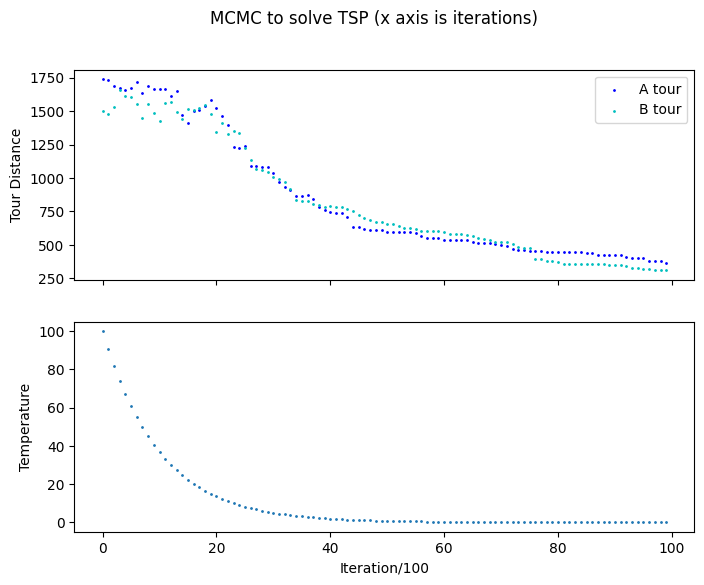

In [7]:
import matplotlib.pyplot as plt

ms = 1 # marker size

# Generate x-axis values (indices of the array)
indices = np.arange(len(tracking_data['dist_arr_a']))

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8, 6))
fig.suptitle('MCMC to solve TSP (x axis is iterations)')

# Create a line plot
ax1.scatter(indices, tracking_data['dist_arr_a'], c='b', marker='o', s=ms)
ax1.scatter(indices, tracking_data['dist_arr_b'], c='c', marker='o', s=ms)
ax1.legend(["A tour", "B tour"])
ax1.set_ylabel('Tour Distance')

ax2.scatter(indices, tracking_data['temp_arr'], marker='o', s=ms)
ax2.set_ylabel('Temperature')
ax2.set_xlabel('Iteration/100')


# Show the plot
plt.show()

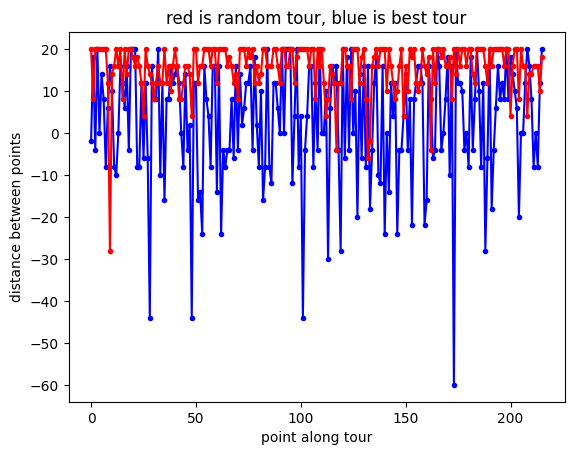

In [8]:
def get_tour_scores(tour):
    score_list = []
    for i in range(len(tour)-1):
        score_list.append(scores[tour[i], tour[i+1]])
    return score_list

random_tour = np.random.permutation(len(data_raw))

best_score_list = get_tour_scores(best_tour)
rand_score_list = get_tour_scores(random_tour)

indices = np.arange(len(best_score_list))

# Create a line plot
plt.plot(indices, best_score_list, c='b', marker='.')
plt.plot(indices, rand_score_list, c='r', marker='.')

# Add titles and labels
plt.title('red is random tour, blue is best tour')
plt.xlabel('point along tour')
plt.ylabel('distance between points')

# Show the plot
plt.show()

In [9]:
for k, index in enumerate(best_tour[:10]):
    poem = data_raw[index]
    score = scores[best_tour[k], best_tour[k+1]]
    print(poem)
    print("\n", score, "\n")

Secretly I wonder if his loss of fertility will coincide with my gain. I am days away from the middle of my cycle, but I know that I'm playing a game of chance. This cycle I am using test strips, capturing a tablespoon of urine each afternoon and watching it draw purple lines on thin slips of paper. So far, the correct hormone surge has eluded me, but the time is not quite right yet.

 -2.0 

After the shower, I look over my right shoulder for the faint outline of my scar, the speckled splotchy redness of its slow disappearance, and when I don't find it I wonder if that scar is even mine, or if I am remembering S\_\_\_’s bike accident, or the old bike accident of a friend. My body merges and then falls to pieces. Perhaps I am not myself, and even my body has become the accumulation of mere memory.

 18.0 

I am being stretched. I fling myself against the wall of my own words. I crack open. I feel like a yolk. I simmer and then, shiver. I am trying to tell you something. My hands are pl

## Step 5: Calculate breathing / break points

To let the poems breath a little bit, find the poems with the most distance between them to create more vertical space between some of the poems.

In [10]:
def get_break_points(tour, percent=20):
    """
    for a given tour, find the poems in the tour with the worst
    distance between that poem and the next poem. (i.e., the 
    highest distance.) return the worst, set by percent.
    
    these are the poems after which there should be a breakpoint.
    
    returns a list of poem indeces.
    """
    score_data = []
    for i in range(len(tour)-1):
        score = scores[tour[i], tour[i+1]]
        poem1 = tour[i]
        poem2 = tour[i+1]
        score_data.append((score, poem1, poem2))
        
    score_data_sorted = sorted(score_data, key=lambda x: x[0], reverse=True)
    breakpoints = [item[1] for item in score_data_sorted[:percent]]
    
#     for i in range(3):
#         print(f"poem {score_data_sorted[i][1]}:\n{data_raw[score_data_sorted[i][1]]}")
#         print(f">>>>>>score: {score_data_sorted[i][0]}")
#         print(f"poem {score_data_sorted[i][2]}:\n{data_raw[score_data_sorted[i][2]]}\n\n")
    
    return breakpoints

get_break_points(best_tour)

[26,
 106,
 5,
 34,
 30,
 16,
 90,
 14,
 68,
 74,
 75,
 83,
 205,
 125,
 124,
 196,
 127,
 160,
 157,
 181]

## Step 6: Calculate mixture levels

As book printing progresses, the mixture level should increase and then oscillate. Below is a simple function that lets the mixture level oscillate with some randomness while still increasing over time.

Text(0, 0.5, 'Mixture Level')

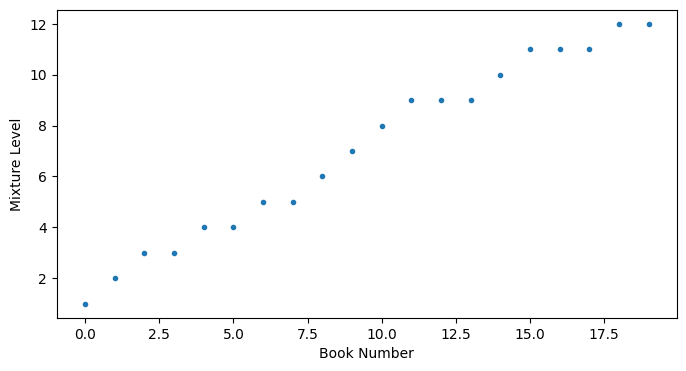

In [11]:
np.random.seed(30324)

NUM_BOOKS = 20

level = 0 # this is the mixture level
level_arr = np.empty(NUM_BOOKS)
for i in range(NUM_BOOKS):
#     change = random.choices([-1,0,+1], weights=[level+20,50,120-level])[0]
    weights = np.array([level + 20, 50, 120 - level])
    probabilities = weights / weights.sum()
    change = np.random.choice([-1, 0, 1], p=probabilities)
    level = level + change
    level = min(max(0, level), 100)
    level_arr[i] = level


plt.figure(figsize=(8,4))
plt.scatter(range(len(level_arr)), level_arr, marker='.')
plt.xlabel('Book Number')
plt.ylabel('Mixture Level')

## Step 7: Let's write out the actual text of the books

In [23]:
import format

log_dist = np.empty(NUM_BOOKS)
log_mixt = np.empty(NUM_BOOKS)
log_tours = np.empty([NUM_BOOKS, 217])
log_breakpoints = np.empty([NUM_BOOKS, 20])

np.random.seed(30324)

print("finished book ", end="")
for book_num in range(NUM_BOOKS):

    mixture = int(level_arr[book_num])
    version_name = f"booknum{book_num:07}-mix{mixture}"

    tour, tracking_data = solver(dist_matrix, iters, temp, mixture)

    breakpoints = get_break_points(tour)

    log_dist[book_num] = tracking_data['dist_arr_a'][-1] + tracking_data['dist_arr_b'][-1]
    log_mixt[book_num] = mixture
    log_tours[book_num] = tour
    log_breakpoints[book_num] = breakpoints

    # Map poems and breaks to parts
    part_1_items = []
    part_2_items = []
    for k, index in enumerate(tour):
        if k < split_index:
            part_1_items.append(data_raw[index])
            if index in breakpoints:
                part_1_items.append("<BREAK>")
        else:
            part_2_items.append(data_raw[index])
            if index in breakpoints:
                part_2_items.append("<BREAK>")
    # Send to formatter script for rendering to PDF
    format.render_version(
        output_dir="output",
        output_name=version_name,
        part_1_items=part_1_items,
        part_2_items=part_2_items,
        book_number=book_num,
        debug=False,
    )
    print(book_num, end="...")

finished book formatting book number: 0
0...formatting book number: 1
1...formatting book number: 2
2...formatting book number: 3
3...formatting book number: 4
4...formatting book number: 5
5...formatting book number: 6
6...formatting book number: 7
7...formatting book number: 8
8...formatting book number: 9
9...formatting book number: 10
10...formatting book number: 11
11...formatting book number: 12
12...formatting book number: 13
13...formatting book number: 14
14...formatting book number: 15
15...formatting book number: 16
16...formatting book number: 17
17...formatting book number: 18
18...formatting book number: 19
19...

[Text(0.5, 23.52222222222222, 'poem number'),
 Text(50.722222222222214, 0.5, 'tour number')]

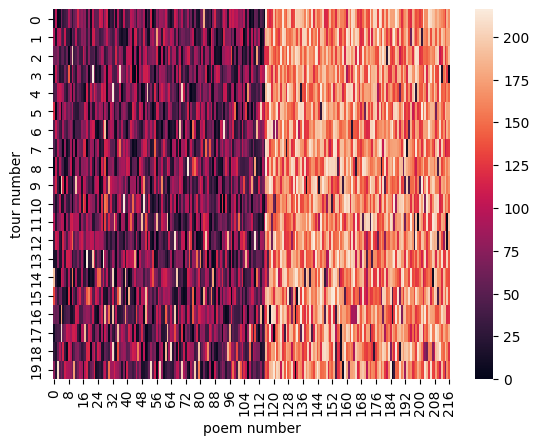

In [19]:
import seaborn as sns

ax = sns.heatmap(log_tours)
ax.set(xlabel = "poem number", ylabel="tour number")

In [47]:
log_breakpoints[10]

array([ 26.,  62.,  56.,  74.,  50.,  58.,  13.,  23.,  30.,  14.,   5.,
        40., 160., 196., 134., 208., 129., 121., 200.,  17.])

In [48]:
data_raw[200]

'Have I become permanently tired?'

Text(0, 0.5, 'Book Number')

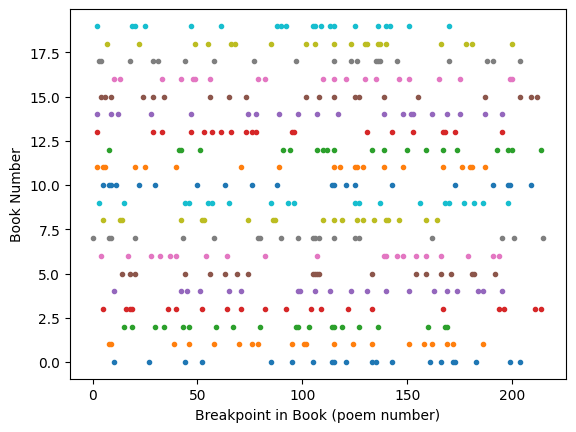

In [39]:
for row_index, row in enumerate(log_breakpoints):
    local_tour = log_tours[row_index]
    x_values = [np.where(local_tour==r)[0][0] for r in row]
    y_values = [row_index] * len(row)

    # Plot the points for the current row
    plt.scatter(x_values, y_values, label=f'Row {row_index}', marker=".")

plt.xlabel('Breakpoint in Book (poem number)')
plt.ylabel('Book Number')

## Step 8: Make graphs for the technical afternote

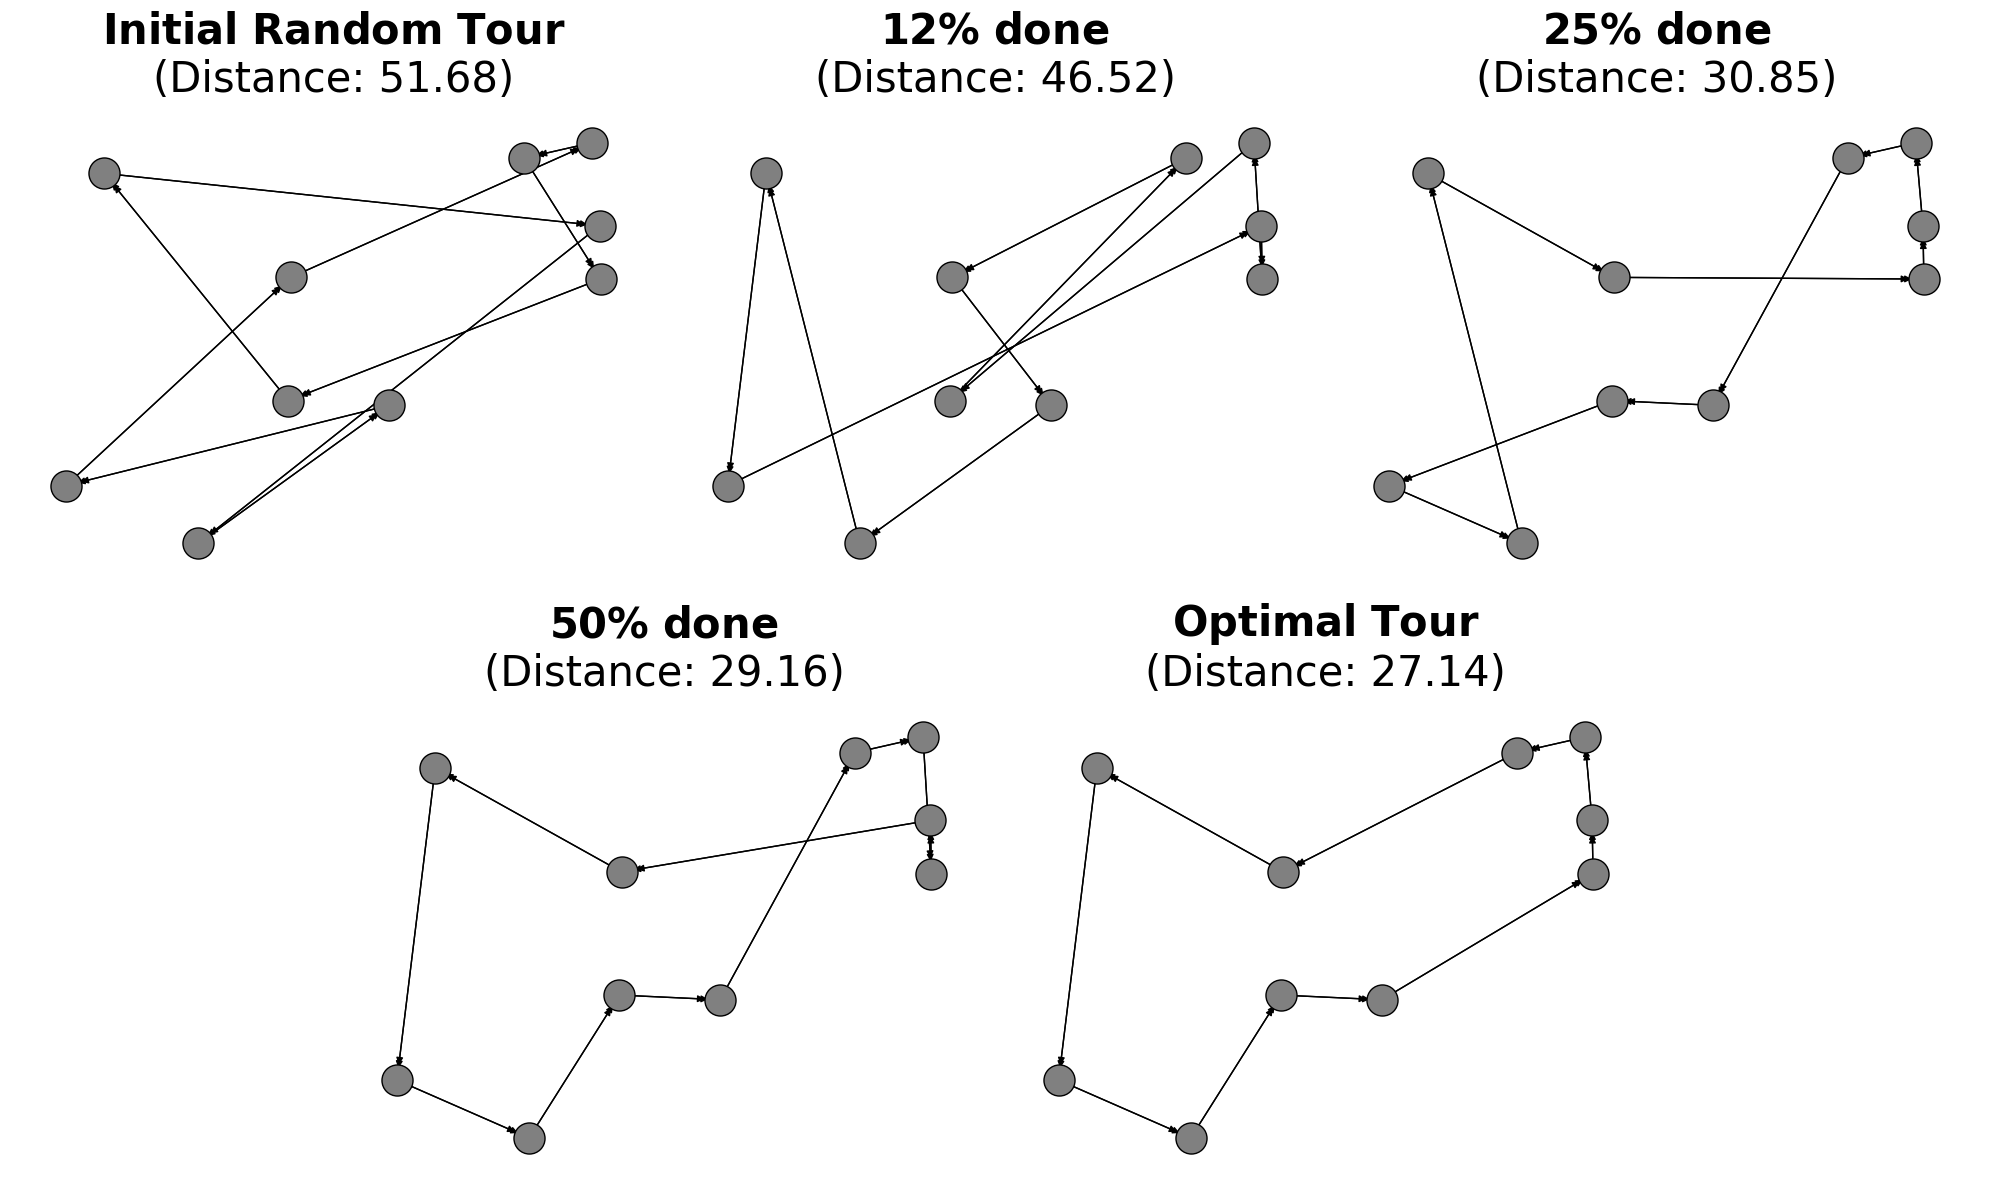

In [257]:
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import networkx as nx
from scipy.spatial import distance
import random

# Set random seed for reproducibility
np.random.seed(45)
random.seed(42)

# Generate random 2D coordinates for 10 nodes
num_nodes = 10
coordinates = np.random.rand(num_nodes, 2) * 10

# Create a distance matrix
dist_matrix = distance.cdist(coordinates, coordinates, metric='euclidean')

# Function to calculate the total distance of a tour
def calculate_distance(tour):
    return sum(dist_matrix[tour[i], tour[(i + 1) % len(tour)]] for i in range(len(tour)))

# Function to plot a tour
def plot_tour(tour, title, ax):
    G = nx.DiGraph()
    for i in range(len(tour)):
        start = tour[i]
        end = tour[(i + 1) % len(tour)]
        G.add_edge(start, end)
    
    pos = {i: coordinates[i] for i in range(num_nodes)}
    nx.draw(G, pos, with_labels=False, node_size=500, node_color='grey', edgecolors='black', ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax)
    ax.set_title(title, fontsize=30)

# MCMC TSP solver with detailed midways
def mcmc_tsp_solver_with_detailed_midways(coordinates, iterations=1000, temperature=5.0, cooling_rate=0.995):
    # Start with a random tour
    initial_tour = list(range(len(coordinates)))
    random.shuffle(initial_tour)
    current_tour = initial_tour[:]
    current_distance = calculate_distance(current_tour)
    
    best_tour = current_tour[:]
    best_distance = current_distance

    # Track midway tours at 1/8, 1/4, and 1/2 through the iterations
    midway_tours = {}
    checkpoints = [int(iterations * fraction) for fraction in [0.125, 0.25, 0.5]]

    for iteration in range(iterations):
        # Generate a new tour by swapping two random nodes
        new_tour = current_tour[:]
        i, j = random.sample(range(len(coordinates)), 2)
        new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
        new_distance = calculate_distance(new_tour)

        # Accept the new tour based on Metropolis criterion
        if new_distance < current_distance or random.random() < np.exp((current_distance - new_distance) / temperature):
            current_tour, current_distance = new_tour, new_distance
            # Update the best tour found so far
            if current_distance < best_distance:
                best_tour, best_distance = current_tour[:], current_distance

        # Capture the midway tours
        if iteration in checkpoints and iteration not in midway_tours:
            midway_tours[iteration] = current_tour[:]

        # Cool down the temperature
        temperature *= cooling_rate

    return initial_tour, midway_tours, best_tour, best_distance

# Run the MCMC solver and capture the initial, midway, and optimal tours
initial_tour, midway_tours, optimal_tour, optimal_distance = mcmc_tsp_solver_with_detailed_midways(coordinates)

# Unpack the midway tours
midway_tour_1, midway_tour_2, midway_tour_3 = (midway_tours[checkpoint] for checkpoint in sorted(midway_tours))

# Plot the tours
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2, 6, figure=fig)
# Top row: 3 plots (each spanning 2 columns)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

# Bottom row: 2 centered plots (spanning columns 1-3 and 3-5)
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

plot_tour(initial_tour, r'$\bf{Initial\ Random\ Tour}$' +f"\n(Distance: {calculate_distance(initial_tour):.2f})", ax1)
plot_tour(midway_tour_1, r'$\bf{12\%\ done}$' + f"\n(Distance: {calculate_distance(midway_tour_1):.2f})", ax2)
plot_tour(midway_tour_2, r"$\bf{25\%\ done}$" + f"\n(Distance: {calculate_distance(midway_tour_2):.2f})", ax3)
plot_tour(midway_tour_3, r"$\bf{50\%\ done}$" + f"\n(Distance: {calculate_distance(midway_tour_3):.2f})", ax4)
plot_tour(optimal_tour, r"$\bf{Optimal\ Tour}$" + f"\n(Distance: {optimal_distance:.2f})", ax5)

plt.tight_layout()
plt.savefig("assets/tour_optimization.png", bbox_inches="tight")
plt.show()


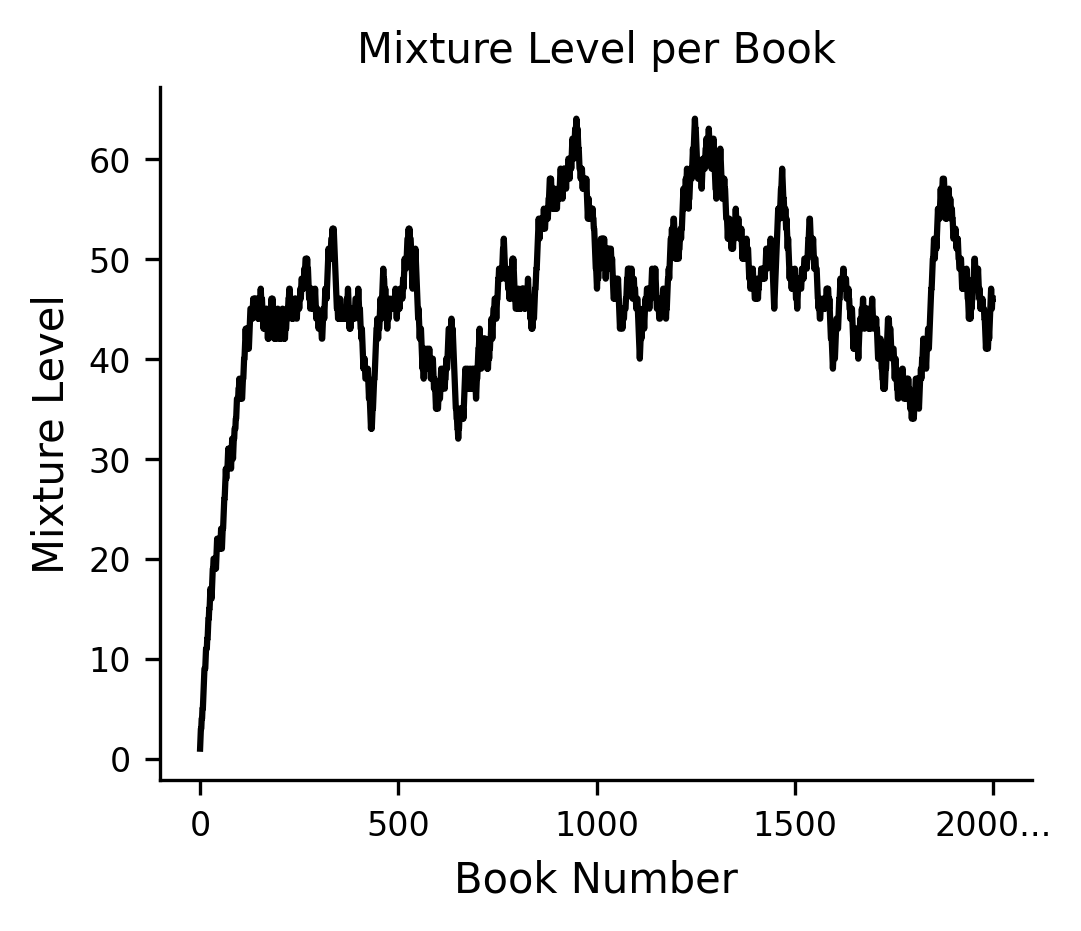

In [258]:
np.random.seed(30324)

num_books = 2000

level = 0 # this is the mixture level
level_arr = np.empty(num_books)
for i in range(num_books):
#     change = random.choices([-1,0,+1], weights=[level+20,50,120-level])[0]
    weights = np.array([level + 20, 50, 120 - level])
    probabilities = weights / weights.sum()
    change = np.random.choice([-1, 0, 1], p=probabilities)
    level = level + change
    level = min(max(0, level), 100)
    level_arr[i] = level

plt.figure(figsize=(3.75, 3), dpi=300)
plt.plot(range(num_books), level_arr, color='black')
plt.xlabel('Book Number', fontsize=10)
plt.ylabel('Mixture Level', fontsize=10)
plt.title('Mixture Level per Book', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)

ax = plt.gca()

def x_formatter(x, pos):
    ticks = ax.get_xticks()
    max_tick = ticks[-1]
    if x == num_books:
        return f'{int(x)}...'
    else:
        return f'{int(x)}'

ax.xaxis.set_major_formatter(mticker.FuncFormatter(x_formatter))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("assets/mixture_level.png", bbox_inches="tight")
plt.show()